In [1]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

### Dataset: VHM Historical Data



In [2]:
df = pd.read_csv('../Datasets/1 - VHM Historical Data.csv')
df = df.dropna()

df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
df = df.set_index('Date')
df = df.sort_index()

temp_data = df.reset_index()

# Format column "Price", "Open", "High", "Low"
for col in ['Price', 'Open', 'High', 'Low']:
    df[col] = df[col].str.replace(',', '').astype(float)

df = df[['Price']]
df


,Price
Date,
2019-03-01,68421.0
2019-03-04,70075.0
2019-03-05,68421.0
2019-03-06,69022.0
2019-03-07,69173.0
...,...
2024-05-27,39800.0
2024-05-28,39950.0
2024-05-29,39450.0


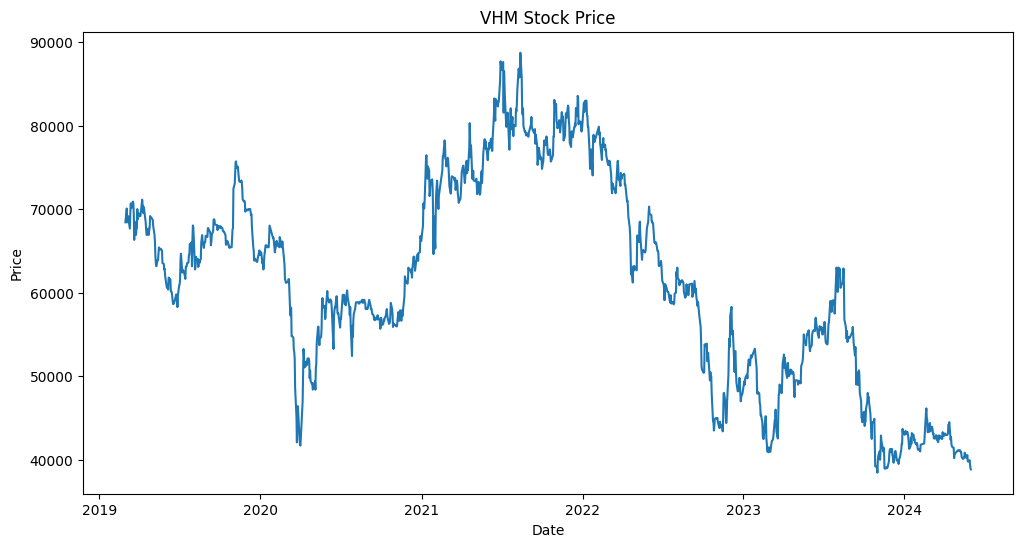

In [3]:
# Visualize the data
plt.figure(figsize=(12, 6))
plt.plot(df['Price'])
plt.title('VHM Stock Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [4]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df=scaler.fit_transform(np.array(df).reshape(-1,1))

#### Ratio 7:3

In [5]:
# 4. Chia train test
train_size = round(0.7 * len(df))
test_size = round(len(df) - train_size)

train_data = df[:train_size]
test_data = df[train_size:]

In [6]:
# 5. Hàm Create Dataset
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [7]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [8]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [9]:
# 8. Define LSTM Model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

d:\LearnPython\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [10]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - loss: 0.1782
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - loss: 0.0196
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - loss: 0.0105
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - loss: 0.0071
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - loss: 0.0064
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - loss: 0.0056
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - loss: 0.0053
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - loss: 0.0042
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 0.0042
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - loss: 0.0040
Epoch 11/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 0.0043
Epoch 12/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - loss: 0.0039
Epoch 13/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - loss: 0.0039
Epoch 14/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - loss: 0.0037
Epoch 15/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms

In [11]:
# 10. Dự báo dữ liệu test
y_pred=model.predict(X_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step


In [12]:
# 11. Chuẩn hóa dữ liệu ytest, y_pred
ytest=scaler.inverse_transform(ytest.reshape(-1,1))
y_pred=scaler.inverse_transform(y_pred)

In [13]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
# Calculate RMSE for the testing set
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

# Calculate MAPE for the testing set
test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
print("Testing MAPE:", test_mape)

# Calculate MAE for the testing set
test_mae = np.mean(np.abs(y_pred - ytest))
print("Testing MAE:", test_mae)

Testing RMSE: 1527.4861772192316
Testing MAPE: 2.667046093860109
Testing MAE: 1216.1535569539249


In [14]:
# 13. Dự báo 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, future_days):
    x_input = data[-time_step:].reshape(1, -1)
    temp_input = x_input[0].tolist()
    lst_output = []
    i = 0
    while i < future_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input).reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return lst_output

n_steps = 100

pred_30_days = predict_future(model, test_data, n_steps, 30)
pred_60_days = predict_future(model, test_data, n_steps, 60)
pred_90_days = predict_future(model, test_data, n_steps, 90)

pred_30_days = scaler.inverse_transform(np.array(pred_30_days).reshape(-1, 1))
pred_60_days = scaler.inverse_transform(np.array(pred_60_days).reshape(-1, 1))
pred_90_days = scaler.inverse_transform(np.array(pred_90_days).reshape(-1, 1))


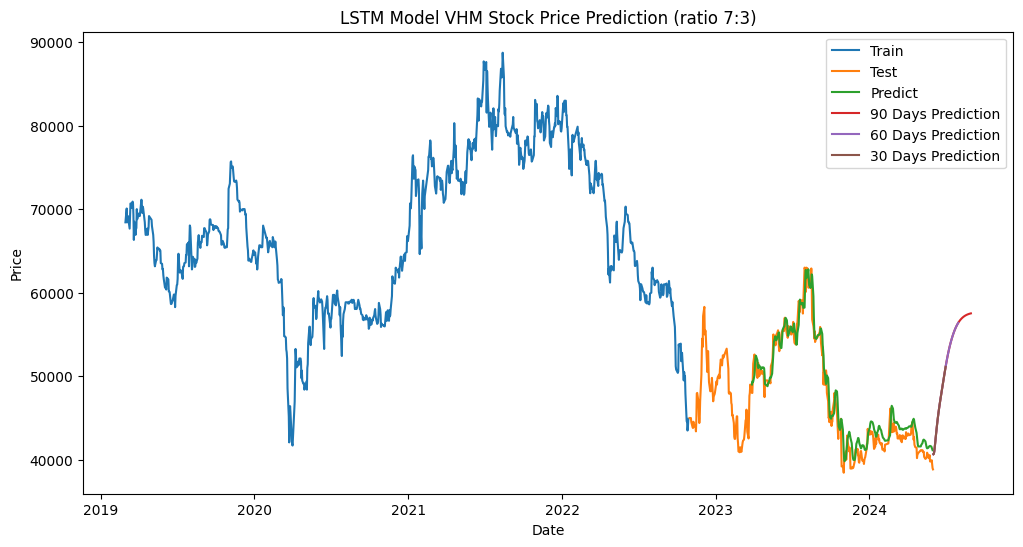

In [15]:
#14. Visualize the prediction
plt.figure(figsize=(12, 6))
dates = pd.to_datetime(temp_data['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')

last_date = dates.iloc[-1]

# Dự đoán cho 30 ngày tiếp theo
future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)

# Dự đoán cho 60 ngày tiếp theo
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60)

# Dự đoán cho 90 ngày tiếp theo
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90)

plt.plot(future_dates_90, np.concatenate((pred_30_days, pred_60_days[30:], pred_90_days[60:])), label='90 Days Prediction')
plt.plot(future_dates_60, np.concatenate((pred_30_days, pred_60_days[30:])), label='60 Days Prediction')
plt.plot(future_dates_30, pred_30_days, label='30 Days Prediction')
plt.title('LSTM Model VHM Stock Price Prediction (ratio 7:3)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.show()

#### Ratio 8:2

In [16]:
# 4. Chia train test
train_size = round(0.8 * len(df))
test_size = round(len(df) - train_size)

train_data = df[:train_size+1]
test_data = df[train_size:]

In [17]:
# 5. Hàm Create Dataset
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [18]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [19]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [20]:
# 8. Define LSTM Model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

d:\LearnPython\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [21]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 112ms/step - loss: 0.1691
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 0.0190
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - loss: 0.0086
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - loss: 0.0058
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - loss: 0.0047
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0046
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 0.0046
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 0.0048
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - loss: 0.0045
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - loss: 0.0044
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - loss: 0.0044
Epoch 12/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 0.0038
Epoch 13/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 0.0037
Epoch 14/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - loss: 0.0038
Epoch 15/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 107

In [22]:
# 10. Dự báo dữ liệu test
y_pred=model.predict(X_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step


In [23]:
# 11. Chuẩn hóa dữ liệu ytest, y_pred
ytest=scaler.inverse_transform(ytest.reshape(-1,1))
y_pred=scaler.inverse_transform(y_pred.reshape(-1,1))

In [24]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
# Calculate RMSE for the testing set
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

# Calculate MAPE for the testing set
test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
print("Testing MAPE:", test_mape)

# Calculate MAE for the testing set
test_mae = np.mean(np.abs(y_pred - ytest))
print("Testing MAE:", test_mae)

Testing RMSE: 1391.844188102089
Testing MAPE: 2.8303349339109327
Testing MAE: 1178.161892361111


In [25]:
# 13. Dự báo 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, future_days):
    x_input = data[-time_step:].reshape(1, -1)
    temp_input = x_input[0].tolist()
    lst_output = []
    i = 0
    while i < future_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input).reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return lst_output

n_steps = 100

pred_30_days = predict_future(model, test_data, n_steps, 30)
pred_60_days = predict_future(model, test_data, n_steps, 60)
pred_90_days = predict_future(model, test_data, n_steps, 90)

pred_30_days = scaler.inverse_transform(np.array(pred_30_days).reshape(-1, 1))
pred_60_days = scaler.inverse_transform(np.array(pred_60_days).reshape(-1, 1))
pred_90_days = scaler.inverse_transform(np.array(pred_90_days).reshape(-1, 1))


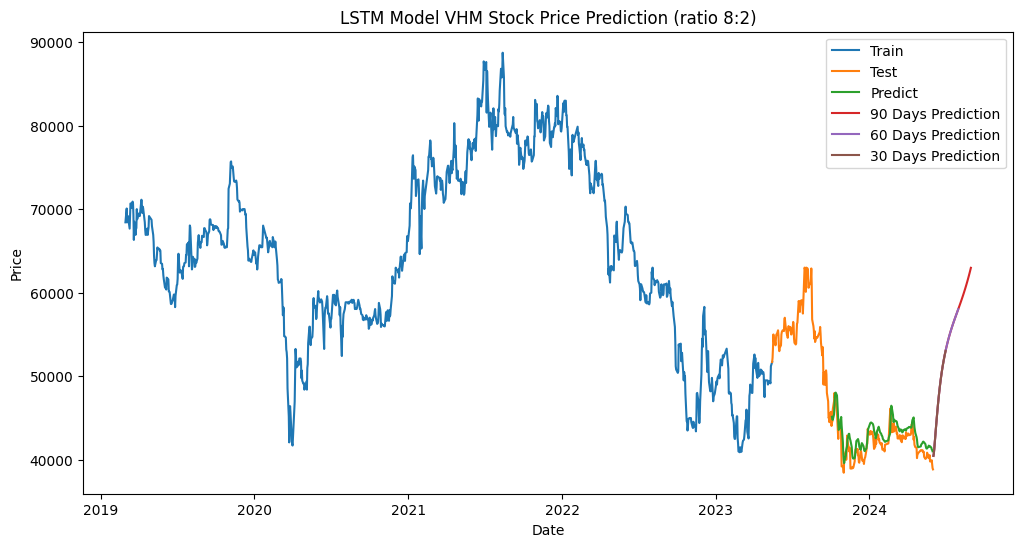

In [27]:
#14. Visualize the prediction
plt.figure(figsize=(12, 6))
dates = pd.to_datetime(temp_data['Date'])

plt.plot(dates[:train_size+1], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')

last_date = dates.iloc[-1]

# Dự đoán cho 30 ngày tiếp theo
future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)

# Dự đoán cho 60 ngày tiếp theo
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60)

# Dự đoán cho 90 ngày tiếp theo
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90)

plt.plot(future_dates_90, np.concatenate((pred_30_days, pred_60_days[30:], pred_90_days[60:])), label='90 Days Prediction')
plt.plot(future_dates_60, np.concatenate((pred_30_days, pred_60_days[30:])), label='60 Days Prediction')
plt.plot(future_dates_30, pred_30_days, label='30 Days Prediction')
plt.title('LSTM Model VHM Stock Price Prediction (ratio 8:2)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.show()

#### Radio 9:1

In [28]:
# 4. Chia train test
train_size = round(0.9 * len(df))
test_size = round(len(df) - train_size)

train_data = df[:train_size+1]
test_data = df[train_size:]

In [29]:
# 5. Hàm Create Dataset
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [30]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [31]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [32]:
# 8. Define LSTM Model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

d:\LearnPython\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [33]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - loss: 0.0837
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.0107
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0060
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0049
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.0044
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - loss: 0.0045
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - loss: 0.0042
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - loss: 0.0043
Epoch 9/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - loss: 0.0039
Epoch 10/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - loss: 0.0035
Epoch 11/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - loss: 0.0034
Epoch 12/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0035
Epoch 13/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - loss: 0.0033
Epoch 14/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - loss: 0.0032
Epoch 15/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms

In [34]:
# 10. Dự báo dữ liệu test
y_pred=model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step


In [35]:
# 11. Chuẩn hóa dữ liệu ytest, y_pred
ytest=scaler.inverse_transform(ytest.reshape(-1,1))
y_pred=scaler.inverse_transform(y_pred)

In [36]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
# Calculate RMSE for the testing set
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

# Calculate MAPE for the testing set
test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
print("Testing MAPE:", test_mape)

# Calculate MAE for the testing set
test_mae = np.mean(np.abs(y_pred - ytest))
print("Testing MAE:", test_mae)

Testing RMSE: 897.5307203342884
Testing MAPE: 1.8661956917691132
Testing MAE: 758.9819010416667


In [37]:
# 13. Dự báo 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, future_days):
    x_input = data[-time_step:].reshape(1, -1)
    temp_input = x_input[0].tolist()
    lst_output = []
    i = 0
    while i < future_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input).reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return lst_output

n_steps = 100

pred_30_days = predict_future(model, test_data, n_steps, 30)
pred_60_days = predict_future(model, test_data, n_steps, 60)
pred_90_days = predict_future(model, test_data, n_steps, 90)

pred_30_days = scaler.inverse_transform(np.array(pred_30_days).reshape(-1, 1))
pred_60_days = scaler.inverse_transform(np.array(pred_60_days).reshape(-1, 1))
pred_90_days = scaler.inverse_transform(np.array(pred_90_days).reshape(-1, 1))


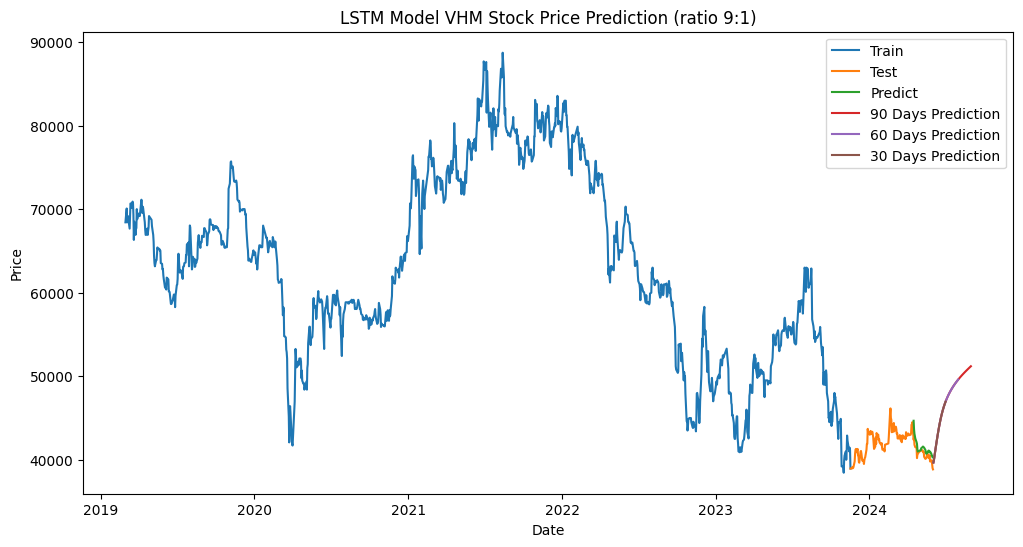

In [38]:
#14. Visualize the prediction
plt.figure(figsize=(12, 6))
dates = pd.to_datetime(temp_data['Date'])

plt.plot(dates[:train_size+1], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')

last_date = dates.iloc[-1]

# Dự đoán cho 30 ngày tiếp theo
future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)

# Dự đoán cho 60 ngày tiếp theo
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60)

# Dự đoán cho 90 ngày tiếp theo
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90)

plt.plot(future_dates_90, np.concatenate((pred_30_days, pred_60_days[30:], pred_90_days[60:])), label='90 Days Prediction')
plt.plot(future_dates_60, np.concatenate((pred_30_days, pred_60_days[30:])), label='60 Days Prediction')
plt.plot(future_dates_30, pred_30_days, label='30 Days Prediction')
plt.title('LSTM Model VHM Stock Price Prediction (ratio 9:1)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.show()

### Dataset: NVL Historical Data


In [39]:
df = pd.read_csv('../Datasets/2 - NVL Historical Data.csv')
df = df.dropna()

df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
df = df.set_index('Date')
df = df.sort_index()

temp_data = df.reset_index()

# Format column "Price", "Open", "High", "Low"
for col in ['Price', 'Open', 'High', 'Low']:
    df[col] = df[col].str.replace(',', '').astype(float)

df = df[['Price']]
df


,Price
Date,
2019-03-01,32933.0
2019-03-04,33100.0
2019-03-05,32711.0
2019-03-06,31709.0
2019-03-07,31932.0
...,...
2024-05-27,14500.0
2024-05-28,14500.0
2024-05-29,14150.0


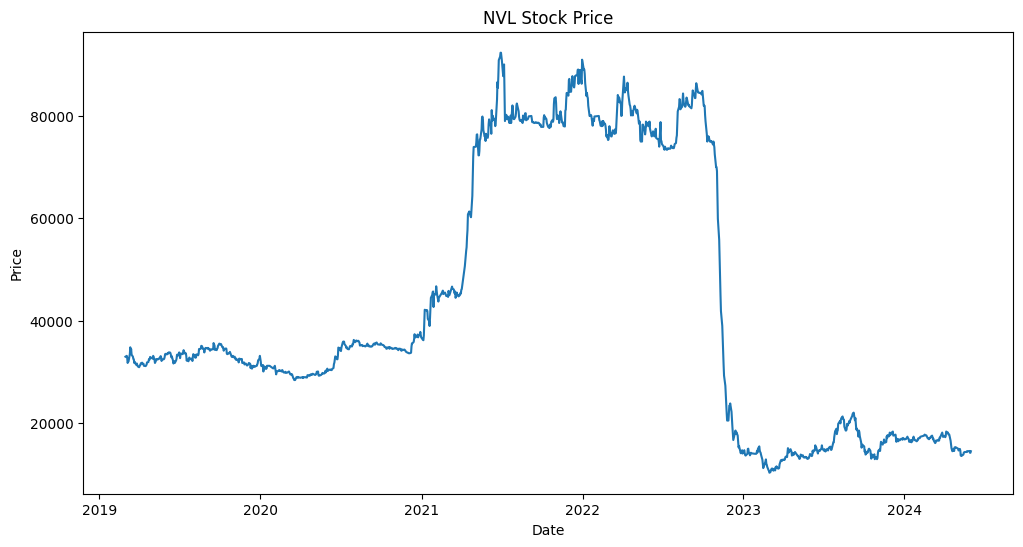

In [40]:
# Visualize the data
plt.figure(figsize=(12, 6))
plt.plot(df['Price'])
plt.title('NVL Stock Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [41]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df=scaler.fit_transform(np.array(df).reshape(-1,1))

#### Ratio 7:3

In [42]:
# 4. Chia train test
train_size = round(0.7 * len(df))
test_size = round(len(df) - train_size)

train_data = df[:train_size + 1]
test_data = df[train_size:]

In [43]:
# 5. Hàm Create Dataset
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [44]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [45]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [46]:
# 8. Define LSTM Model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

d:\LearnPython\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [47]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 120ms/step - loss: 0.2404
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - loss: 0.0192
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - loss: 0.0090
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - loss: 0.0037
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - loss: 0.0020
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - loss: 0.0018
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - loss: 0.0015
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step - loss: 0.0018
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 168ms/step - loss: 0.0017
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step - loss: 0.0018
Epoch 11/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - loss: 0.0015
Epoch 12/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - loss: 0.0015
Epoch 13/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - loss: 0.0018
Epoch 14/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - loss: 0.0016
Epoch 15/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 1

In [48]:
# 10. Dự báo dữ liệu test
y_pred=model.predict(X_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step


In [49]:
# 11. Chuẩn hóa dữ liệu ytest, y_pred
ytest=scaler.inverse_transform(ytest.reshape(-1,1))
y_pred=scaler.inverse_transform(y_pred)

In [50]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
# Calculate RMSE for the testing set
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

# Calculate MAPE for the testing set
test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
print("Testing MAPE:", test_mape)

# Calculate MAE for the testing set
test_mae = np.mean(np.abs(y_pred - ytest))
print("Testing MAE:", test_mae)

Testing RMSE: 2233.9619399791304
Testing MAPE: 12.688187884923064
Testing MAE: 2009.6737947952217


In [51]:
# 13. Dự báo 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, future_days):
    x_input = data[-time_step:].reshape(1, -1)
    temp_input = x_input[0].tolist()
    lst_output = []
    i = 0
    while i < future_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input).reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return lst_output

n_steps = 100

pred_30_days = predict_future(model, test_data, n_steps, 30)
pred_60_days = predict_future(model, test_data, n_steps, 60)
pred_90_days = predict_future(model, test_data, n_steps, 90)

pred_30_days = scaler.inverse_transform(np.array(pred_30_days).reshape(-1, 1))
pred_60_days = scaler.inverse_transform(np.array(pred_60_days).reshape(-1, 1))
pred_90_days = scaler.inverse_transform(np.array(pred_90_days).reshape(-1, 1))


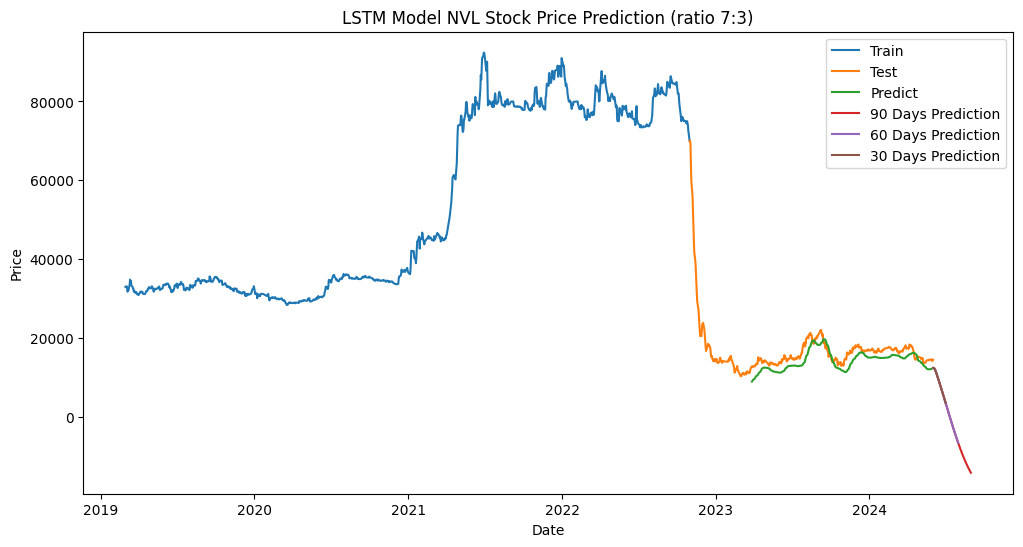

In [52]:
#14. Visualize the prediction
plt.figure(figsize=(12, 6))
dates = pd.to_datetime(temp_data['Date'])

plt.plot(dates[:train_size+1], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')

last_date = dates.iloc[-1]

# Dự đoán cho 30 ngày tiếp theo
future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)

# Dự đoán cho 60 ngày tiếp theo
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60)

# Dự đoán cho 90 ngày tiếp theo
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90)

plt.plot(future_dates_90, np.concatenate((pred_30_days, pred_60_days[30:], pred_90_days[60:])), label='90 Days Prediction')
plt.plot(future_dates_60, np.concatenate((pred_30_days, pred_60_days[30:])), label='60 Days Prediction')
plt.plot(future_dates_30, pred_30_days, label='30 Days Prediction')
plt.title('LSTM Model NVL Stock Price Prediction (ratio 7:3)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.show()

#### Ratio 8:2

In [53]:
# 4. Chia train test
train_size = round(0.8 * len(df))
test_size = round(len(df) - train_size)

train_data = df[:train_size]
test_data = df[train_size:]

In [54]:
# 5. Hàm Create Dataset
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [55]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [56]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [57]:
# 8. Define LSTM Model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

d:\LearnPython\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [58]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 0.1636
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.0208
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.0064
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.0049
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.0037
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 0.0034
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.0031
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.0028
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.0021
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.0021
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.0018
Epoch 12/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.0023
Epoch 13/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0023
Epoch 14/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0017
Epoch 15/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - lo

In [59]:
# 10. Dự báo dữ liệu test, val
y_pred=model.predict(X_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step


In [60]:
# 11. Chuẩn hóa dữ liệu ytest, y_pred
ytest=scaler.inverse_transform(ytest.reshape(-1,1))
y_pred=scaler.inverse_transform(y_pred)

In [61]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
# Calculate RMSE for the testing set
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

# Calculate MAPE for the testing set
test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
print("Testing MAPE:", test_mape)

# Calculate MAE for the testing set
test_mae = np.mean(np.abs(y_pred - ytest))
print("Testing MAE:", test_mae)

Testing RMSE: 776.6917098519025
Testing MAPE: 3.6456971607985555
Testing MAE: 576.3178047839506


In [62]:
# 13. Dự báo 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, future_days):
    x_input = data[-time_step:].reshape(1, -1)
    temp_input = x_input[0].tolist()
    lst_output = []
    i = 0
    while i < future_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input).reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return lst_output

n_steps = 100

pred_30_days = predict_future(model, test_data, n_steps, 30)
pred_60_days = predict_future(model, test_data, n_steps, 60)
pred_90_days = predict_future(model, test_data, n_steps, 90)

pred_30_days = scaler.inverse_transform(np.array(pred_30_days).reshape(-1, 1))
pred_60_days = scaler.inverse_transform(np.array(pred_60_days).reshape(-1, 1))
pred_90_days = scaler.inverse_transform(np.array(pred_90_days).reshape(-1, 1))


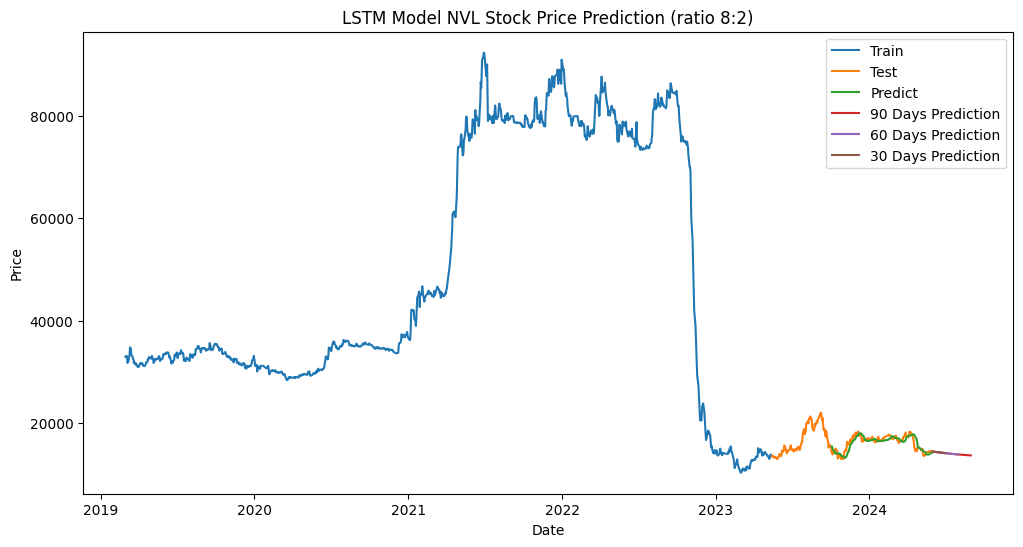

In [63]:
#14. Visualize the prediction
plt.figure(figsize=(12, 6))
dates = pd.to_datetime(temp_data['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')

last_date = dates.iloc[-1]

# Dự đoán cho 30 ngày tiếp theo
future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)

# Dự đoán cho 60 ngày tiếp theo
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60)

# Dự đoán cho 90 ngày tiếp theo
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90)

plt.plot(future_dates_90, np.concatenate((pred_30_days, pred_60_days[30:], pred_90_days[60:])), label='90 Days Prediction')
plt.plot(future_dates_60, np.concatenate((pred_30_days, pred_60_days[30:])), label='60 Days Prediction')
plt.plot(future_dates_30, pred_30_days, label='30 Days Prediction')
plt.title('LSTM Model NVL Stock Price Prediction (ratio 8:2)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.show()

#### Radio 9:1

In [64]:
# 4. Chia train test
train_size = round(0.9 * len(df))
test_size = round(len(df) - train_size)

train_data = df[:train_size]
test_data = df[train_size:]

In [65]:
# 5. Hàm Create Dataset
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [66]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [67]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [68]:
# 8. Define LSTM Model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

d:\LearnPython\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [69]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: 0.1070
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0103
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 0.0044
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 0.0039
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.0031
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.0039
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.0023
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0023
Epoch 9/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.0017
Epoch 10/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0016
Epoch 11/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0016
Epoch 12/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0019
Epoch 13/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0018
Epoch 14/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0019
Epoch 15/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - lo

In [70]:
# 10. Dự báo dữ liệu test
y_pred=model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


In [71]:
# 11. Chuẩn hóa dữ liệu ytest, y_pred
ytest=scaler.inverse_transform(ytest.reshape(-1,1))
y_pred=scaler.inverse_transform(y_pred)

In [72]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
# Calculate RMSE for the testing set
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

# Calculate MAPE for the testing set
test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
print("Testing MAPE:", test_mape)

# Calculate MAE for the testing set
test_mae = np.mean(np.abs(y_pred - ytest))
print("Testing MAE:", test_mae)

Testing RMSE: 1146.9338515187285
Testing MAPE: 5.166486173075576
Testing MAE: 755.91640625


In [73]:
# 13. Dự báo 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, future_days):
    x_input = data[-time_step:].reshape(1, -1)
    temp_input = x_input[0].tolist()
    lst_output = []
    i = 0
    while i < future_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input).reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return lst_output

n_steps = 100

pred_30_days = predict_future(model, test_data, n_steps, 30)
pred_60_days = predict_future(model, test_data, n_steps, 60)
pred_90_days = predict_future(model, test_data, n_steps, 90)

pred_30_days = scaler.inverse_transform(np.array(pred_30_days).reshape(-1, 1))
pred_60_days = scaler.inverse_transform(np.array(pred_60_days).reshape(-1, 1))
pred_90_days = scaler.inverse_transform(np.array(pred_90_days).reshape(-1, 1))

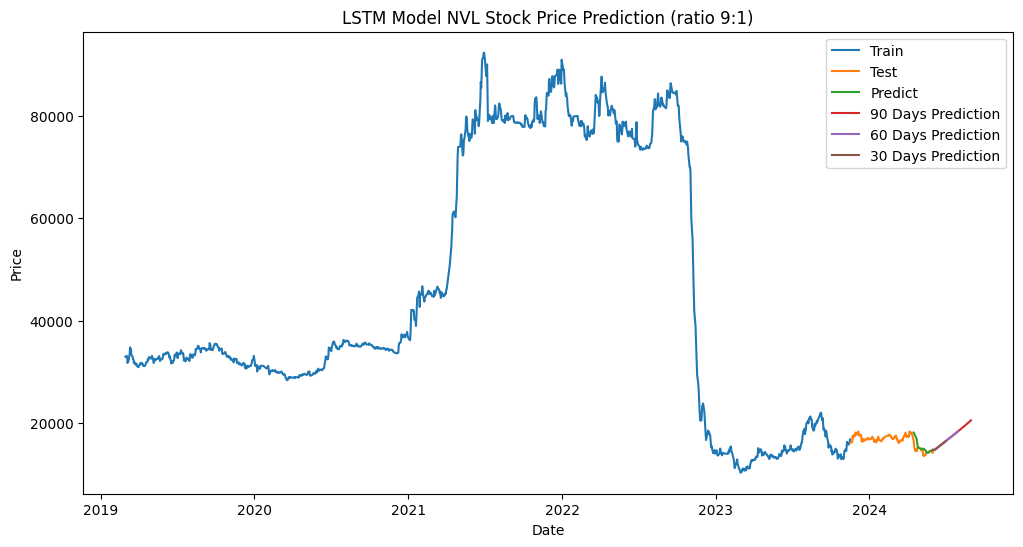

In [74]:
#14. Visualize the prediction
plt.figure(figsize=(12, 6))
dates = pd.to_datetime(temp_data['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')

last_date = dates.iloc[-1]

# Dự đoán cho 30 ngày tiếp theo
future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)

# Dự đoán cho 60 ngày tiếp theo
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60)

# Dự đoán cho 90 ngày tiếp theo
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90)

plt.plot(future_dates_90, np.concatenate((pred_30_days, pred_60_days[30:], pred_90_days[60:])), label='90 Days Prediction')
plt.plot(future_dates_60, np.concatenate((pred_30_days, pred_60_days[30:])), label='60 Days Prediction')
plt.plot(future_dates_30, pred_30_days, label='30 Days Prediction')
plt.title('LSTM Model NVL Stock Price Prediction (ratio 9:1)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.show()

### Dataset: NLG Historical Data


In [75]:
df = pd.read_csv('../Datasets/3 - NLG Historical Data.csv')
df = df.dropna()

df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
df = df.set_index('Date')
df = df.sort_index()

temp_data = df.reset_index()

# Format column "Price", "Open", "High", "Low"
for col in ['Price', 'Open', 'High', 'Low']:
    df[col] = df[col].str.replace(',', '').astype(float)

df = df[['Price']]
df

,Price
Date,
2019-03-01,18706.8
2019-03-04,19127.2
2019-03-05,18917.0
2019-03-06,18846.9
2019-03-07,18706.8
...,...
2024-05-27,43900.0
2024-05-28,43701.0
2024-05-29,44400.0


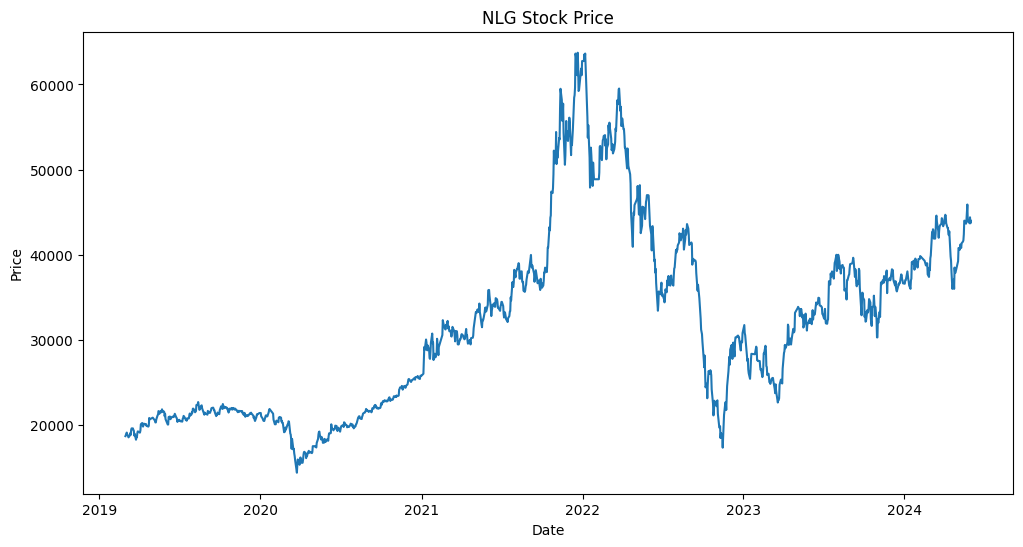

In [76]:
# Visualize the data
plt.figure(figsize=(12, 6))
plt.plot(df['Price'])
plt.title('NLG Stock Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [77]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df=scaler.fit_transform(np.array(df).reshape(-1,1))

#### Ratio 7:3

In [78]:
# 4. Chia train test
train_size = round(0.7 * len(df))
test_size = round(len(df) - train_size)

train_data = df[:train_size]
test_data = df[train_size:]

In [79]:
# 5. Hàm Create Dataset
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [80]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [81]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [82]:
# 8. Define LSTM Model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

d:\LearnPython\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [83]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 0.1506
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0123
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0075
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0046
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0035
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0034
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 0.0036
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0035
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.0028
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0027
Epoch 11/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0026
Epoch 12/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.0023
Epoch 13/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 0.0022
Epoch 14/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.0022
Epoch 15/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - lo

In [84]:
# 10. Dự báo dữ liệu test
y_pred=model.predict(X_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step


In [85]:
# 11. Chuẩn hóa dữ liệu ytest, y_pred
ytest=scaler.inverse_transform(ytest.reshape(-1,1))
y_pred=scaler.inverse_transform(y_pred)

In [86]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
# Calculate RMSE for the testing set
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

# Calculate MAPE for the testing set
test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
print("Testing MAPE:", test_mape)

# Calculate MAE for the testing set
test_mae = np.mean(np.abs(y_pred - ytest))
print("Testing MAE:", test_mae)

Testing RMSE: 1425.951365899416
Testing MAPE: 3.095181749408857
Testing MAE: 1117.4968936646758


In [87]:
# 13. Dự báo 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, future_days):
    x_input = data[-time_step:].reshape(1, -1)
    temp_input = x_input[0].tolist()
    lst_output = []
    i = 0
    while i < future_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input).reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return lst_output

n_steps = 100

pred_30_days = predict_future(model, test_data, n_steps, 30)
pred_60_days = predict_future(model, test_data, n_steps, 60)
pred_90_days = predict_future(model, test_data, n_steps, 90)

pred_30_days = scaler.inverse_transform(np.array(pred_30_days).reshape(-1, 1))
pred_60_days = scaler.inverse_transform(np.array(pred_60_days).reshape(-1, 1))
pred_90_days = scaler.inverse_transform(np.array(pred_90_days).reshape(-1, 1))

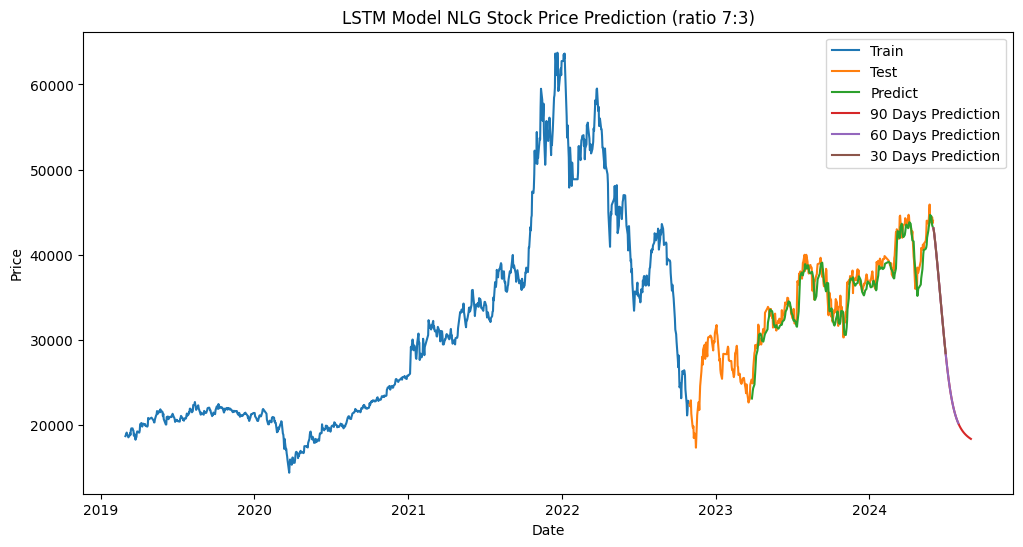

In [88]:
#14. Visualize the prediction
plt.figure(figsize=(12, 6))
dates = pd.to_datetime(temp_data['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')

last_date = dates.iloc[-1]

# Dự đoán cho 30 ngày tiếp theo
future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)

# Dự đoán cho 60 ngày tiếp theo
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60)

# Dự đoán cho 90 ngày tiếp theo
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90)

plt.plot(future_dates_90, np.concatenate((pred_30_days, pred_60_days[30:], pred_90_days[60:])), label='90 Days Prediction')
plt.plot(future_dates_60, np.concatenate((pred_30_days, pred_60_days[30:])), label='60 Days Prediction')
plt.plot(future_dates_30, pred_30_days, label='30 Days Prediction')
plt.title('LSTM Model NLG Stock Price Prediction (ratio 7:3)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

#### Ratio 8:2

In [89]:
# 4. Chia train test
train_size = round(0.8 * len(df))
test_size = round(len(df) - train_size)

train_data = df[:train_size]
test_data = df[train_size:]

In [90]:
# 5. Hàm Create Dataset
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [91]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [92]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [93]:
# 8. Define LSTM Model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

d:\LearnPython\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [94]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - loss: 0.0864
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0111
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.0042
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 0.0040
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.0033
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.0030
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.0029
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.0028
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.0026
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.0020
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 0.0021
Epoch 12/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.0018
Epoch 13/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0020
Epoch 14/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.0017
Epoch 15/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - lo

In [95]:
# 10. Dự báo dữ liệu test
y_pred=model.predict(X_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step


In [96]:
# 11. Chuẩn hóa dữ liệu ytest, y_pred
ytest=scaler.inverse_transform(ytest.reshape(-1,1))
y_pred=scaler.inverse_transform(y_pred)

In [97]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
# Calculate RMSE for the testing set
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

# Calculate MAPE for the testing set
test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
print("Testing MAPE:", test_mape)

# Calculate MAE for the testing set
test_mae = np.mean(np.abs(y_pred - ytest))
print("Testing MAE:", test_mae)

Testing RMSE: 1078.1741422195278
Testing MAPE: 2.1831242728906344
Testing MAE: 824.010296103395


In [98]:
# 13. Dự báo 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, future_days):
    x_input = data[-time_step:].reshape(1, -1)
    temp_input = x_input[0].tolist()
    lst_output = []
    i = 0
    while i < future_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input).reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return lst_output

n_steps = 100

pred_30_days = predict_future(model, test_data, n_steps, 30)
pred_60_days = predict_future(model, test_data, n_steps, 60)
pred_90_days = predict_future(model, test_data, n_steps, 90)

pred_30_days = scaler.inverse_transform(np.array(pred_30_days).reshape(-1, 1))
pred_60_days = scaler.inverse_transform(np.array(pred_60_days).reshape(-1, 1))
pred_90_days = scaler.inverse_transform(np.array(pred_90_days).reshape(-1, 1))


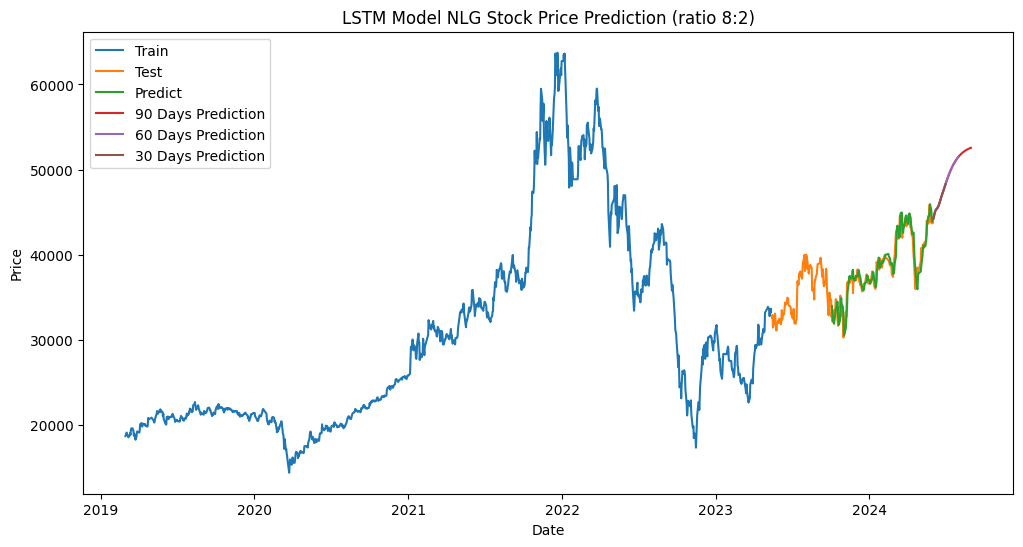

In [99]:
#14. Visualize the prediction
plt.figure(figsize=(12, 6))
dates = pd.to_datetime(temp_data['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')

last_date = dates.iloc[-1]

# Dự đoán cho 30 ngày tiếp theo
future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)

# Dự đoán cho 60 ngày tiếp theo
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60)

# Dự đoán cho 90 ngày tiếp theo
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90)

plt.plot(future_dates_90, np.concatenate((pred_30_days, pred_60_days[30:], pred_90_days[60:])), label='90 Days Prediction')
plt.plot(future_dates_60, np.concatenate((pred_30_days, pred_60_days[30:])), label='60 Days Prediction')
plt.plot(future_dates_30, pred_30_days, label='30 Days Prediction')
plt.title('LSTM Model NLG Stock Price Prediction (ratio 8:2)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.show()

#### Radio 9:1

In [100]:
# 4. Chia train test
train_size = round(0.9 * len(df))
test_size = round(len(df) - train_size)

train_data = df[:train_size]
test_data = df[train_size:]

In [101]:
# 5. Hàm Create Dataset
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [102]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [103]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [104]:
# 8. Define LSTM Model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

d:\LearnPython\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [105]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - loss: 0.0781
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0080
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 0.0043
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.0042
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.0035
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 0.0032
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0022
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0027
Epoch 9/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.0023
Epoch 10/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.0021
Epoch 11/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.0022
Epoch 12/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.0018
Epoch 13/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 0.0019
Epoch 14/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0018
Epoch 15/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - l

In [106]:
# 10. Dự báo dữ liệu test
y_pred=model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


In [107]:
# 11. Chuẩn hóa dữ liệu ytest, y_pred
ytest=scaler.inverse_transform(ytest.reshape(-1,1))
y_pred=scaler.inverse_transform(y_pred)

In [108]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
# Calculate RMSE for the testing set
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

# Calculate MAPE for the testing set
test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
print("Testing MAPE:", test_mape)

# Calculate MAE for the testing set
test_mae = np.mean(np.abs(y_pred - ytest))
print("Testing MAE:", test_mae)

Testing RMSE: 1172.3204950248103
Testing MAPE: 2.1745581118593598
Testing MAE: 880.09609375


In [109]:
# 13. Dự báo 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, future_days):
    x_input = data[-time_step:].reshape(1, -1)
    temp_input = x_input[0].tolist()
    lst_output = []
    i = 0
    while i < future_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input).reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return lst_output

n_steps = 100

pred_30_days = predict_future(model, test_data, n_steps, 30)
pred_60_days = predict_future(model, test_data, n_steps, 60)
pred_90_days = predict_future(model, test_data, n_steps, 90)

pred_30_days = scaler.inverse_transform(np.array(pred_30_days).reshape(-1, 1))
pred_60_days = scaler.inverse_transform(np.array(pred_60_days).reshape(-1, 1))
pred_90_days = scaler.inverse_transform(np.array(pred_90_days).reshape(-1, 1))


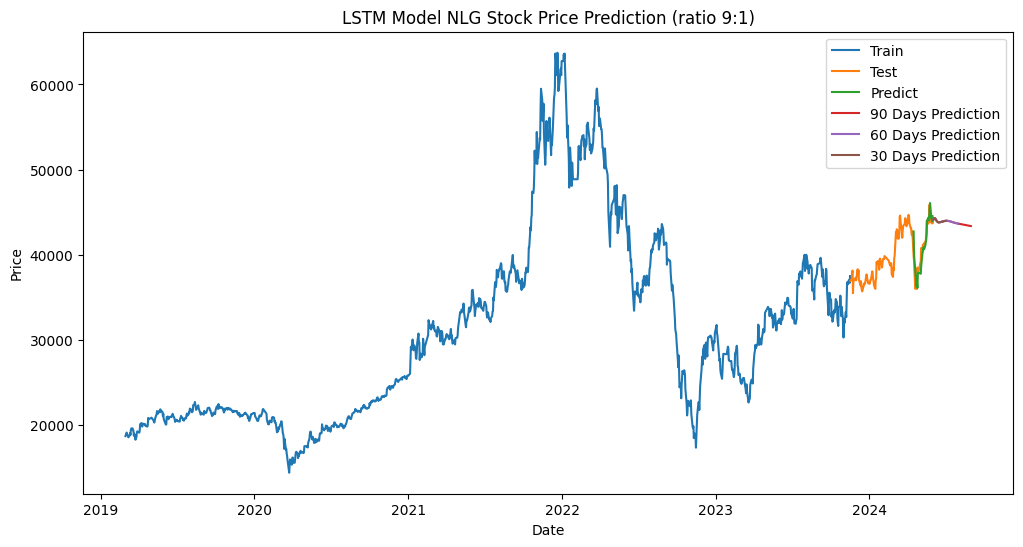

In [110]:
#14. Visualize the prediction
plt.figure(figsize=(12, 6))
dates = pd.to_datetime(temp_data['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')

last_date = dates.iloc[-1]

# Dự đoán cho 30 ngày tiếp theo
future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)

# Dự đoán cho 60 ngày tiếp theo
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60)

# Dự đoán cho 90 ngày tiếp theo
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90)

plt.plot(future_dates_90, np.concatenate((pred_30_days, pred_60_days[30:], pred_90_days[60:])), label='90 Days Prediction')
plt.plot(future_dates_60, np.concatenate((pred_30_days, pred_60_days[30:])), label='60 Days Prediction')
plt.plot(future_dates_30, pred_30_days, label='30 Days Prediction')
plt.title('LSTM Model NLG Stock Price Prediction (ratio 9:1)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.show()